In [1]:
import enum
import sys
import itertools
import bisect
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

In [2]:
Bateau = dict() # values are [nbr_case, valeur_pixel]
Bateau['porte_avions'] = [5, 10]
Bateau['croiseur'] = [4, 20]
Bateau['contre_torpilleurs'] = [3, 30]
Bateau['sous_marin'] = [3, 40]
Bateau['torpilleur'] = [2, 50]


class Direction(enum.Enum):
    horizontal = 1
    vertical = 2

In [3]:
isinstance(Direction.horizontal, Direction)

True

In [4]:
class Localisation():
    def __init__(self, pair_xy, direction, length):
        assert(isinstance(pair_xy, tuple) or isinstance(pair_xy, list))
        assert(len(pair_xy) == 2)
        assert(int(length) > 0)
        assert(isinstance(direction, Direction))
        
        self.pair_xy = pair_xy
        self.direction = direction
        self.length = length
        
    def equals(self, Loc2):
        assert(isinstance(Loc2, Localisation))
        return (self.pair_xy == Loc2.pair_xy and self.direction == Loc2.direction and self.length == Loc2.length)
    
    def __lt__(self, Loc2):
        """
            will be used by bisect.insort, to make the list of localisations sorted
        """
        return self.pair_xy < Loc2.pair_xy
    
    def __str__(self):
        s = "Localisation object: \n"
        s += "[+] coord: " + str(self.pair_xy) + '\n'
        s += "[+] direction: " + str(self.direction) +  " -> value: " + str(self.direction.value) + '\n'
        s += "[+] length of the ship: " + str(self.length) + '\n'
        
        return s

In [5]:
class Grille():
    def __init__(self, lines=10, cols=10):
        self.grille = np.zeros((lines, cols), dtype=int) # 0 means empty
        self.lines = lines
        self.cols = cols
        self.localisations = [] # list of localisations (where the ships are in the grid)
        
    def peut_placer(self, bateau, position, direction): # position is a tuple: (line, col)
        """
            @params: bateau -> str (key in Bateau dictionnary)
                     position -> tuple or list
                     direction -> Direction enum instance.
        """
        assert(bateau in Bateau)
        assert(len(position) == 2)
        assert(isinstance(direction, Direction))
        
        try:
            line = position[0]
            column = position[1]
            nbr_case = Bateau[bateau][0]

            if direction.value == Direction.horizontal.value:
                placement = self.grille[line, column:][:nbr_case]
                if sum(placement) == 0 and len(placement) == nbr_case:
                    return True
                return False

            elif direction.value == Direction.vertical.value:
                placement = self.grille[:, column][line:nbr_case + line]
                #print("placement %s => sum = %d", %(placement, sum(placement)))
                if sum(placement) == 0 and len(placement) == nbr_case:
                    return True
                return False

            else:
                raise ValueError("Direction doit etre soit vertical soit horizontal")
        except IndexError:
            return False
    
    def place(self, bateau, position, direction):
        # assertions will be done by peut_placer
        
        if self.peut_placer(bateau, position, direction):
            line = position[0]
            column = position[1]
            
            if direction.value == Direction.horizontal.value:
                self.grille[line, column:][:Bateau[bateau][0]] = Bateau[bateau][1]
            elif direction.value == Direction.vertical.value:
                self.grille[:, column][line:Bateau[bateau][0] + line] = Bateau[bateau][1]
            
            # using insort to keep the list sorted each insert (needed to compare 2 grids)
            bisect.insort(self.localisations, Localisation(list(position), direction, Bateau[bateau][0]))
            
            return True
            
        else:
            return False
            
    def place_alea(self, bateau):
        cols_list = list(range(self.cols))
        lines_list = list(range(self.lines))

        all_possible_positions = list(itertools.product(cols_list, lines_list)) # construct all possible pairs (coords)
        directions = [direction for direction in Direction]
        
        random_index = np.random.randint(len(all_possible_positions))
        random_direction = directions[np.random.randint(len(directions))] # returns a direction (type Direction enum)
        
        placed = self.place(bateau, all_possible_positions[random_index], random_direction)
        
        while not placed:
            del all_possible_positions[random_index] # sans remise
            
            random_index = np.random.randint(len(all_possible_positions))
            random_direction = directions[np.random.randint(len(directions))]
            placed = self.place(bateau, all_possible_positions[random_index], random_direction)
            
        bisect.insort(self.localisations, Localisation(list(all_possible_positions[random_index]), \
                                                       random_direction, Bateau[bateau][0]))
            
    def affiche(self):
        plt.imshow(self.grille)
        plt.set_cmap('hot')
        
    def eq(self, grilleB): # works only by constructions
        if (len(self.localisations) != len(grilleB.localisations)):
            return False
        
        for i in range(len(self.localisations)):
            if not self.localisations[i].equals(grilleB.localisations[i]):
                return False
        
        return True
    
    def genere_grille(self, h_many = 5):
        i = 0
        
        for bateau in Bateau:
            if i == h_many:
                break
                
            self.place_alea(bateau)
            i += 1
            
    def remove_ship(self, ship, position, direction):
        line = position[0]
        column = position[1]
        nbr_case = Bateau[ship][0]
        
        if direction.value == Direction.horizontal.value:
            self.grille[line, column:][:nbr_case] = 0
            
        elif direction.value == Direction.vertical.value:
            self.grille[:, column][line:nbr_case + line] = 0

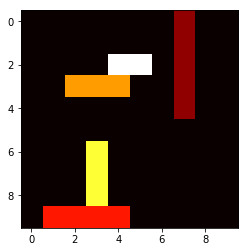

In [6]:
grille = Grille()
grille.genere_grille()
grille.affiche()

## 2 Combinatoire du jeu

Donner une borne supérieure du nombre de configurations possibles pour la liste
complète de bateaux sur une grille de taille 10 (calcul à la main).

In [7]:
# fonction qui permet de dénombrer le nombre de façons de placer un bateau donné sur une grille vide
def how_many_ways_to_put(grid, ship_len, lines):
    """
        Assumption: the grid is represented as a SQUARE matrix
        
        @params: grid 
                 ship_len -> longueur du bateau 
                 lines -> number of lines in the grid
    """
    assert(isinstance(grid, Grille))
    assert(isinstance(ship_len, int) and ship_len > 0)
    
    #grid = Grille(lines, lines)
    count = 0
    Bateau['temp'] = [ship_len, 100]
    
    for i in range(lines):
        for j in range(lines):
            if grid.peut_placer('temp', (i,j), Direction.horizontal):
                count += 1
            
            if grid.peut_placer('temp', (i,j), Direction.vertical):
                count += 1
    
    del Bateau['temp']
    
    return count

In [8]:
def construct_ships(ships_length, colors=None):
    ships = []
    i = 0
    
    for ship_len in ships_length: 
        color = np.random.randint(10, 150)
        ship_name = str(ship_len + color) + 'D' + str(ships_length.count(ship_len))
        ships.append(ship_name)
        
        if colors is not None:
            Bateau[ship_name] = [ship_len, colors[i]]
            i += 1
        else:
            Bateau[ship_name] = [ship_len, color] 
    
    return ships

In [9]:
def calculate(grid, ships, lines, cols, count, visualize):    
    
    if len(ships) == 1:
        for i in range(lines):
            for j in range(cols):
                for direction in Direction:
                    if grid.peut_placer(ships[0], (i,j), direction):
                        
                        if visualize:
                            grid.place(ships[0], (i,j), direction)
                            grid.affiche()
                            show()
                            grid.remove_ship(ships[0], (i,j), direction)
                            
                        count += 1
                            
    else:
        for i in range(lines):
            for j in range(cols):
                for direction in Direction:
                    if grid.peut_placer(ships[0], (i,j), direction):
                        grid.place(ships[0], (i,j), direction)
                        count = calculate(grid, ships[1:], lines, cols, count, visualize)
                        
                        if count % 3 == 0:
                            sys.stdout.write("\r%d" % count)
                            sys.stdout.flush()
                        grid.remove_ship(ships[0], (i,j), direction)
                            
    return count

In [10]:
# fonction qui permet de dénombrer le nombre de façon de placer une liste de bateaux sur une grille vide. 
def how_many_conf(ships_length, lines, cols, visualize = False):
    grid = Grille(lines, cols)
    ships = construct_ships(ships_length)
    
    count = calculate(grid, ships, lines, cols, 0, visualize)
    
    for ship in ships:
        try:
            del Bateau[ship]
        except KeyError:
            pass
        
    return count

In [11]:
#how_many_conf([5, 4, 3, 3, 2], 10, 10)

In [12]:
def how_much_to_get_grid(grid):
    # fonction qui prend enparamètre une grille, génère des grilles aléatoirement jusqu’à ce que la grille 
    # générée soit égale à la grille passée en paramètre et qui renvoie le nombre de grilles générées.
    count = 1
    
    # constructing new ships with the same lengths and colors
    uniq, counts = (np.unique(grid.grille, return_counts=True))
    
    ships = dict(zip(uniq[1:], counts[1:]))
    ships = construct_ships(list(ships.values()), list(ships.keys()))
    
    # constructing new grids
    tmp = Grille(grid.lines, grid.cols)
    is_the_same = False
    
    for ship in ships:
        tmp.place_alea(ship)
        
    if tmp.eq(grid):
        is_the_same = True
        
    while not is_the_same:
        count += 1
        
        tmp = Grille(grid.lines, grid.cols)

        for ship in ships:
            tmp.place_alea(ship)

        if tmp.eq(grid):
            is_the_same = True
            
        if count % 3 == 0:
            sys.stdout.write("\r%d" % count)
            sys.stdout.flush()
    
    # deleting temp ships
    
    for ship in ships:
        try:
            del Bateau[ship]
        except KeyError:
            pass
    
    return count

In [13]:
class Bataille:
    def __init__(self):
        self.grid = Grille()
        self.grid.genere_grille()
        self.__construct_targets() 
        self.reseted = True
        
    def __construct_targets(self):
        s = "target_"
        i = 1
        self.targets = dict() # dictionnary where keys are tuples (positions), and value is a tuple (ship, hitted?)
        self.not_hitted_list = [] # list of targets (ints) that are still not hitted yet.
            
        for location in self.grid.localisations:
            s += str(i)
            
            start_pos = tuple(location.getPos())
            line, col = start_pos[0], start_pos[1]
            
            # start_pos is included in both loops
            
            if location.direction.value == Direction.horizontal.value: # iterate over the columns at the same line
                for ii in range(location.length):
                    self.targets[(line, col+ii)] = [s, False]
                    
            elif location.direction.value == Direction.vertical.value: # iterate over the lines at the same column
                for ii in range(location.length):
                    self.targets[(line+ii, col)] = [s, False]
            
            else:
                raise SystemExit("Something is not right. (location)")
            
            self.not_hitted_list.append(s) # constructing this list too
            
            i += 1
            s = "target_"
            
        
    def reset(self):
        if not self.reseted:
            self.grid.reset()
            self.grid.genere_grille()
            self.__construct_targets() 
        
        self.reseted = True
        
    def play(self, pos):
        pos = tuple(pos)
        assert(len(pos) == 2)
        
        line, col = pos[0], pos[1]
        assert(line < self.grid.lines and col < self.grid.cols)
        
        if self.grid.grille[line, col] == -1:
            print("Already hitted this place.", end='\t')
        
        elif pos in self.targets: # hitted a target
            hitted_target = self.targets[pos][0]
            print("Hitted " + hitted_target, end='\t')
            
            if not self.targets[pos][1]: # mark the target as hitted if it's not marked yet
                # iterate over the dictionnary, and mark all positions of target as hitted
                for pos in self.targets.keys():
                    if self.targets[pos][0] == hitted_target:
                        self.targets[pos][1] = True # hitted
                        
                # remove the hitted target from not_hitted_list
                self.not_hitted_list.remove(hitted_target)
                
                return True
                
        else:
            print("Missed !", end='\t')
            
        self.grid.grille[line, col] = -1 # hitted
            
        if self.victory():
            print()
            print("Victory !!!")
            
        self.reseted = False # important, so that when we call reset x times, we'll do it only once, unless we play again
        
        return False
                
    def victory(self):
        return len(self.not_hitted_list) == 0
    
    def show(self):
        self.grid.affiche()

In [14]:
b = Bataille()
b.show()

AttributeError: 'Localisation' object has no attribute 'getPos'

In [ ]:
b.not_hitted_list

In [ ]:
class RandomPlayer():
    """
        A player that plays randomly (randomly choose a position and hit.)
        Each time he chooses a random position (never choose the same position twice.)
    """
    
    def __init__(self, bataille):
        assert(isinstance(bataille, Bataille))
        self.bataille = bataille
        
        cols_list = list(range(self.bataille.grid.cols))
        lines_list = list(range(self.bataille.grid.lines))
        
        self.positions = list(itertools.product(cols_list, lines_list))
        
    def play(self):
        random_index = np.random.randint(len(self.positions))
        self.bataille.play(self.positions[random_index])
        
        del self.positions[random_index]

In [ ]:
player = RandomPlayer(b)
count = 0
b.reset()
while not b.victory():
    player.play()
    count += 1
    
print(count)
b.show()

In [ ]:
class HeuristicPlayer():
    """
        A player that plays randomly (randomly choose a position and hit.)
        Each time he chooses a random position (never choose the same position twice.)
    """
    
    def __init__(self, bataille, h_far=1):
        assert(isinstance(bataille, Bataille))
        assert(int(h_far) > 0)
        
        self.bataille = bataille
        self.h_far = h_far
        
        cols_list = list(range(self.bataille.grid.cols))
        lines_list = list(range(self.bataille.grid.lines))
        
        self.positions = list(itertools.product(cols_list, lines_list))
    
    def get_surroundings(self, index, h_far=None):
        """
            @params:
                [+] index: index of positions ( a tuple )
                [+] h_far: how far away we'll go (an int)
                
            explores the rectangle surrounding a point.
            
                    * * *
                    * P *
                    * * *
            
            returns a list of indices in self.positions to hit
            
        """
        assert(int(index) >= 0)
        assert(index < len(self.positions))
        
        if h_far is None:
            h_far = self.h_far
        
        assert(int(h_far) > 0)
        
        surr = []
        line, col = self.positions[index]
        
        for j in range(h_far):
            try:
                surr.append(self.positions.index((line, col-j)))
            except IndexError:
                pass

            try:
                surr.append(self.positions.index((line-j, col)))
            except IndexError:
                pass

            try:
                surr.append(self.positions.index((line-j, col-j)))
            except IndexError:
                pass

            try:
                surr.append(self.positions.index((line, col+j)))
            except IndexError:
                pass

            try:
                surr.append(self.positions.index((line+j, col)))
            except IndexError:
                pass

            try:
                surr.append(self.positions.index((line+j, col+j)))
            except IndexError:
                pass

            try:
                surr.append(self.positions.index((line+j, col-j)))
            except IndexError:
                pass

            try:
                surr.append(self.positions.index((line-j, col+j)))
            except IndexError:
                pass
    
    return surr
    
    def play(self, h_far=None):
        if h_far is None:
            h_far = self.h_far
            
        assert(int(h_far) > 0)
        
        random_index = np.random.randint(len(self.positions))
        
        if self.bataille.play(self.positions[random_index]): # hitted a target
            # explore surroundings
            surr = self.get_surroundings(random_index, h_far)
            
            # hit'em
            for pos in surr:
                self.bataille.play(self.positions[pos])
        
        del self.positions[random_index]
        